# Hyperparemeter optimization of networks to predict wpm


## Set up


In [1]:
# Building on the basic pytorch model in nn-predict.ipynb, develop ML pipeline with 
# hyperparameter optimization
# See https://appsilon.com/pytorch-neural-network-tutorial/ for a simple example

# Set up to use local modules
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, module_path)

In [2]:
import time

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
from sklearn.metrics import root_mean_squared_error


from src import process
from src import models

# Load the CSV file results.csv into a dataframe and add some processed columns
df = process.load_processed_results()
# display(df.head())
# display(df.tail())

## Train network


In [3]:
# Prepare data

# Include trial types above a certain threshold of occurances
min_trial_count = 100
combined_id_value_counts = df["combined_id"].value_counts()
combined_id_value_counts = combined_id_value_counts[
    combined_id_value_counts >= min_trial_count
]

valid_trial_ids = combined_id_value_counts.index.tolist()
feature_cols = ["combined_id", "acc", "trial_num", "trial_type_num"]
target_col = ["wpm"]

X_df = df.loc[
    df["combined_id"].isin(valid_trial_ids),
    feature_cols,
]
Y_df = df[df["combined_id"].isin(valid_trial_ids)][target_col]

# Convert X_df['combined_id'] to a 1-hot encoding
X_df = pd.get_dummies(X_df, columns=["combined_id"]).astype(int)

display(X_df.head())
display(Y_df.head())

,acc,trial_num,trial_type_num,combined_id_2,combined_id_17,combined_id_25,combined_id_29,combined_id_34
5,91,6,1,1,0,0,0,0
6,95,7,2,1,0,0,0,0
7,93,8,3,1,0,0,0,0
8,93,9,4,1,0,0,0,0
9,90,10,5,1,0,0,0,0


,wpm
5,52.39
6,64.39
7,57.79
8,58.39
9,53.79


In [4]:
# Parameters
params = models.get_default_params()

seed = 42
torch.manual_seed(seed)

print(f"Using device: {params.device}")

# Set up data
X = torch.tensor(X_df.values, dtype=torch.float)
y = torch.tensor(Y_df.values, dtype=torch.float)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=params.train_size, random_state=seed
)
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, shuffle=True, batch_size=params.batch_size)
test_loader = DataLoader(test_data, batch_size=len(test_data.tensors[0]))
X_train, y_train = X_train.to(params.device), y_train.to(params.device)
X_test, y_test = X_test.to(params.device), y_test.to(params.device)

Using device: cuda


In [5]:
# Create model
input_n = X.shape[1]
output_n = y.shape[1]
base_model = models.MLPcondensed(input_n, params.n_hidden_units, output_n)
base_model = base_model.to(params.device)

# Set up for training
optimizer = torch.optim.Adam(
    params=base_model.parameters(), lr=params.lr, weight_decay=params.weight_decay
)
scheduler = StepLR(optimizer, step_size=1, gamma=params.gamma)
loss_function = nn.MSELoss()

# Train model
train_loss, test_loss = models.train_and_evaluate(
    base_model, train_loader, test_loader, scheduler, optimizer, loss_function, params
)

Epoch [ 100/1000], Train loss: 239.0130, Test loss: 247.0430, Run Time: 01.68
Epoch [ 200/1000], Train loss: 158.2344, Test loss: 162.8846, Run Time: 03.05
Epoch [ 300/1000], Train loss: 55.2059, Test loss: 68.2448, Run Time: 04.45
Epoch [ 400/1000], Train loss: 38.2576, Test loss: 47.1018, Run Time: 05.93
Epoch [ 500/1000], Train loss: 29.3750, Test loss: 38.3335, Run Time: 07.26
Epoch [ 600/1000], Train loss: 28.6628, Test loss: 33.6621, Run Time: 08.61
Epoch [ 700/1000], Train loss: 24.7078, Test loss: 30.2348, Run Time: 09.98
Epoch [ 800/1000], Train loss: 21.3635, Test loss: 27.4668, Run Time: 11.57
Epoch [ 900/1000], Train loss: 19.9066, Test loss: 26.9456, Run Time: 12.97
Epoch [1000/1000], Train loss: 19.6613, Test loss: 23.7124, Run Time: 14.35


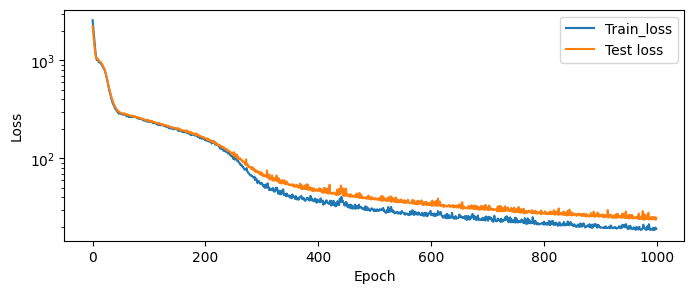

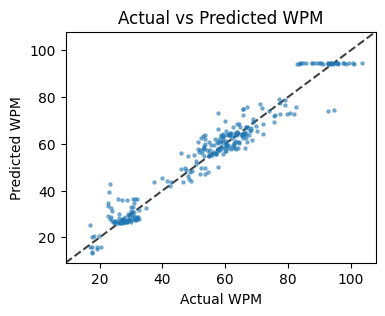

In [6]:
# Plot loss
fig = plt.figure(figsize=(8, 3))
plt.plot(train_loss, label="Train_loss")
plt.plot(test_loss, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.show()

# Plot actual vs predicted wpm
y_pred = base_model(X_test)
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
ax.scatter(y_test.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), alpha=0.5, s=5)
ax.set_xlabel("Actual WPM")
ax.set_ylabel("Predicted WPM")
ax.set_title("Actual vs Predicted WPM")
# Ref line, without affecting axis limits
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, "k--", alpha=0.75, zorder=0)
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## Hyperopt


In [26]:
# Define the space over which hyperopt will search for optimal hyperparameters.

# best loss: 16.306495666503906
# Best hyperparameters: {'gamma': 0.9960181162722727, 'learning_rate': 0.007269113318457658, 'weight_decay': 0.001119076053891545}
space = {
    # loguniform
    "learning_rate": hp.loguniform("learning_rate", np.log(1e-5), np.log(1e-2)),
    "weight_decay": hp.loguniform("weight_decay", np.log(1e-5), np.log(1e-1)),
    "gamma": hp.uniform("gamma", 0.9, 0.999),
    # Fixed
    "log_interval": np.inf,
}

# best loss: 14.207015037536621
# Best hyperparameters: {'gamma': 0.9936028171578175, 'learning_rate': 0.04978030842407764, 'weight_decay': 0.0017546369177781098}
space = {
    # loguniform
    "learning_rate": hp.loguniform("learning_rate", np.log(0.0007), np.log(0.07)),
    "weight_decay": hp.loguniform("weight_decay", np.log(0.0001), np.log(0.01)),
    "gamma": hp.uniform("gamma", 0.99, 0.9999),
    # Fixed
    "log_interval": np.inf,
}

#best loss: 14.22087574005127
#Best hyperparameters: {'gamma': 0.9990809108026611, 'learning_rate': 0.0370470477454688, 'weight_decay': 0.0030818178148805443}
space = {
    # loguniform
    "learning_rate": hp.loguniform("learning_rate", np.log(0.005), np.log(0.5)),
    "weight_decay": hp.loguniform("weight_decay", np.log(0.0001), np.log(0.01)),
    "gamma": hp.uniform("gamma", 0.99, 0.9999),
    # Fixed
    "log_interval": np.inf,
}

In [27]:
# Define the hyperopt objective.
def hyperparameter_tuning(space, verbose=True):
    # Set up the parameters
    # Variable
    params.lr = space["learning_rate"]
    params.weight_decay = space["weight_decay"]
    params.gamma = space["gamma"]
    # Fixed
    params.log_interval = space["log_interval"]

    # Create the model
    input_n = X.shape[1]
    output_n = y.shape[1]
    model = models.MLPcondensed(input_n, params.n_hidden_units, output_n)
    model = model.to(params.device)

    # Set up for training
    optimizer = torch.optim.Adam(
        params=model.parameters(), lr=params.lr, weight_decay=params.weight_decay
    )
    scheduler = StepLR(optimizer, step_size=1, gamma=params.gamma)
    loss_function = nn.MSELoss()

    # Train model
    _, _ = models.train_and_evaluate(
        model, train_loader, test_loader, scheduler, optimizer, loss_function, params
    )
    model.eval()
    y_pred = model(X_test)
    loss = loss_function(y_pred, y_test)

    if verbose:
        print(f"Using varied parameters: {space}")
        print(f"                   Loss: {loss}")
    return {"loss": loss, "status": STATUS_OK, "model": model}

In [28]:
# Run trials.
trials = Trials()
best = fmin(
    fn=hyperparameter_tuning,
    space=space,
    algo=tpe.suggest,
    max_evals=25,
    trials=trials,
)
print(f"Best hyperparameters: {best}")

  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

Using varied parameters: {'gamma': 0.9920151591121197, 'learning_rate': 0.257502109510766, 'log_interval': inf, 'weight_decay': 0.0002795768468648975}
                   Loss: 477.3717956542969            
Using varied parameters: {'gamma': 0.9903471762045842, 'learning_rate': 0.07424565144448764, 'log_interval': inf, 'weight_decay': 0.005699234512242326}
                   Loss: 16.340059280395508                                    
Using varied parameters: {'gamma': 0.9952941391065765, 'learning_rate': 0.16912911034492642, 'log_interval': inf, 'weight_decay': 0.0005545054845378056}
                   Loss: 15.771797180175781                                     
Using varied parameters: {'gamma': 0.9980532646043284, 'learning_rate': 0.2014710012822704, 'log_interval': inf, 'weight_decay': 0.000107855821564358}
                   Loss: 477.4443054199219                                      
Using varied parameters: {'gamma': 0.9966897841219812, 'learning_rate': 0.009095600290322086, 'l

In [21]:
# Create instace of best model.
best_model = trials.results[np.argmin([r["loss"] for r in trials.results])]["model"]

# Examine model hyperparameters
best_model_loss = trials.results[np.argmin([r["loss"] for r in trials.results])]["loss"]
print(f"Final loss (MSE): {best_model_loss:.8f}")
print(f"Best optimized hyperparameters:\n{space_eval(space, best)}")

Final loss (MSE): 14.52180576
Best optimized hyperparameters:
{'gamma': 0.9983420984008621, 'learning_rate': 0.010352692564316706, 'log_interval': inf, 'weight_decay': 0.0033649676145551762}


In [22]:
best_model.eval()
best_model_score = root_mean_squared_error(
    y_test.cpu(), best_model(X_test).cpu().detach().numpy()
)
print("Best Model RMSE:", best_model_score)
#
base_model_score = root_mean_squared_error(
    y_test.cpu(), base_model(X_test).cpu().detach().numpy()
)
print("Base model RMSE:", base_model_score)
# MSE from guessing the mean of the training set
mean_model_score = root_mean_squared_error(
    y_test.cpu(), np.full(y_test.shape, np.mean(y_train.cpu().detach().numpy()))
)
print("Mean model RMSE:", mean_model_score)

Best Model RMSE: 3.8107488
Base model RMSE: 4.9800444
Mean model RMSE: 21.851515
